### SI 670: Final Project Regression Model

#### Step 0. Import necessary libraries/packages and dataset

In [6]:
# Import libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# --- 1. Data Loading and Initial Filtering ---

# Load NFL dataset (loading more years for richer history/lagged features)
df = nfl.import_pbp_data([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

# Define our necessary play types
fantasy_play_types = ['pass', 'run', 'qb_kneel']
exclude_play_types = [
    'no_play',       # Penalties/timeouts
    'qb_spike',      
    'field_goal',    
    'extra_point',   
    'punt',          
    'kickoff',       
]

# Filter DataFrame to include only fantasy_play_types
df_fantasy_plays = df[
    df['play_type'].isin(fantasy_play_types) & 
    ~df['play_type'].isin(exclude_play_types)
].copy()

# --- FIX: Impute Rusher ID for QB Kneels (Essential for target aggregation) ---
# This ensures the QB gets the negative fantasy points for the kneel.
df_fantasy_plays['rusher_player_id'] = np.where(
    (df_fantasy_plays['play_type'] == 'qb_kneel') & 
    df_fantasy_plays['rusher_player_id'].isnull(), 
    df_fantasy_plays['passer_player_id'], 
    df_fantasy_plays['rusher_player_id']
)


# --- 2. Final Clean Play Filtering (Excluding Penalties/2-Point Attempts) ---
df_mdl1 = df_fantasy_plays[
    (df_fantasy_plays['penalty'] == 0) & 
    (df_fantasy_plays['two_point_attempt'] == 0)
].copy()

# --- 3. Column Selection and Setup ---
mdl_cols = [
    # Identifiers and Context (CRITICAL for merging and time-series)
    'game_id', 'play_id', 'season', 'week', 'posteam', 'defteam', 
    'passer_player_id', 'rusher_player_id', 'receiver_player_id', 
    
    # Raw Stats (Used for Y calculation - LEAKAGE if used as X)
    'passing_yards', 'pass_touchdown', 'interception', 
    'rushing_yards', 'rush_touchdown', 'fumble_lost',
    'receiving_yards', 'complete_pass', # complete_pass = reception for PPR
    
    # Efficiency/Context (Non-leaking features after aggregation)
    'play_type', 'yards_gained', 'epa', 'cpoe'
]

# Filter DataFrame for retained columns
df_mdl0 = df_mdl1[mdl_cols].copy()

# --- 4. Define Scoring Rules (Half-PPR) ---
scoring_rules = {
    'pass_yd': 0.04, 'pass_td': 4, 
    'rush_yd': 0.1, 'rush_td': 6, 
    'rec_yd': 0.1, 'rec_td': 6, 
    'rec': 0.5, # Half-PPR point per reception
    'int': -2, 'fumble_lost': -2,
    'qb_kneel_yd': -0.1
}

# --- 5. Calculate Fantasy Points Per Play ---

def calculate_fantasy_points_per_play(df, scoring_rules):
    """Calculates all fantasy points earned on a single play based on half-PPR rules."""
    
    # Passing Points (QB)
    df['fp_pass'] = (df['passing_yards'].fillna(0) * scoring_rules['pass_yd']) + \
                    (df['pass_touchdown'].fillna(0) * scoring_rules['pass_td'])
                                
    # Rushing Points (RB/QB)
    df['fp_rush'] = (df['rushing_yards'].fillna(0) * scoring_rules['rush_yd']) + \
                    (df['rush_touchdown'].fillna(0) * scoring_rules['rush_td'])
                                
    # --- FIX: Calculate Receiving Points conditionally to prevent leakage and ensure accuracy ---
    is_reception = df['complete_pass'].fillna(0) == 1
    
    df['fp_rec'] = np.where(is_reception, 
        (df['receiving_yards'].fillna(0) * scoring_rules['rec_yd']) + \
        (df['pass_touchdown'].fillna(0) * scoring_rules['rec_td']) + \
        (df['complete_pass'].fillna(0) * scoring_rules['rec']),
        0  # Assign 0 if no reception occurred
    )
    
    # Interception (for primary passer)
    df['fp_int'] = df['interception'].fillna(0) * scoring_rules['int']

    # Fumble Lost (for primary ball carrier/or receiver)
    df['fp_fumble_lost'] = df['fumble_lost'].fillna(0) * scoring_rules['fumble_lost']
    df['fp_fumble_penalty'] = df['fp_fumble_lost'].fillna(0) # Separate column for attribution
    
    # QB Kneel Adjustment
    df['fp_kneel'] = np.where(df['play_type'] == 'qb_kneel', 
                              df['yards_gained'].fillna(0) * scoring_rules['qb_kneel_yd'], 0)
    
    return df

df_mdl1 = calculate_fantasy_points_per_play(df_mdl0, scoring_rules)


# --- 6. Calculate and Aggregate Weekly Target (Y_target_points) ---

def calculate_weekly_fantasy_points_final(df):
    """Aggregates all fantasy points earned by a player across a week."""
    
    # Calculate the total points for each respective player id
    df['fp_pass_total'] = df['fp_pass'].fillna(0) + df['fp_int'].fillna(0) + df['fp_kneel'].fillna(0)
    df['fp_rush_total'] = df['fp_rush'].fillna(0)
    df['fp_rec_total'] = df['fp_rec'].fillna(0)
    
    # --- FUMBLE FIX: Apply Fumble PENALTY to all possible roles ---
    id_vars = ['season', 'week']
    
    contributions_map = {
        'passer_player_id': 'fp_pass_total',
        'rusher_player_id': 'fp_rush_total',
        'receiver_player_id': 'fp_rec_total',
        
        # Apply Fumble PENALTY (Negative Points) to the three primary roles 
        # to ensure the correct player is penalized for losing the ball.
        'passer_player_id_fumble': 'fp_fumble_penalty', 
        'rusher_player_id_fumble': 'fp_fumble_penalty',
        'receiver_player_id_fumble': 'fp_fumble_penalty',
    }

    contributions = []
    for id_col_raw, point_col in contributions_map.items():
        id_col = id_col_raw.replace('_fumble', '')
        
        temp_df = df.rename(columns={id_col: 'player_id', point_col: 'points'})
        contributions.append(temp_df[id_vars + ['player_id', 'points']])

    # Stack contributions and drop any missing player ids
    df_all_points = pd.concat(contributions, ignore_index=True)
    df_all_points.dropna(subset=['player_id'], inplace=True)
    
    # Group by week and season for each respective player id and return the table
    df_target_Y = df_all_points.groupby(id_vars + ['player_id'])['points'].sum().reset_index()
    
    return df_target_Y.rename(columns={'points': 'Y_target_points'})

df_target_Y = calculate_weekly_fantasy_points_final(df_mdl1)
print(f"Target variable created successfully. Total player-weeks: {len(df_target_Y)}")

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
Target variable created successfully. Total player-weeks: 54213


#### Step 1. Feature Engineering

1. Define fantasy score rules and target variable.

In [7]:
# --- BLOCK 1: FEATURE AGGREGATION & POSITION INFERENCE ---

# Define aggregation rules: sum for volume stats, mean for efficiency stats
feature_agg_rules = {
    'passing_yards': 'sum',
    'rushing_yards': 'sum',
    'receiving_yards': 'sum',
    'pass_touchdown': 'sum',
    'rush_touchdown': 'sum',
    'interception': 'sum',
    'complete_pass': 'sum', # Used to infer receptions for WR/TE/RB
    'epa': 'mean',
    'cpoe': 'mean',
}

id_vars = ['season', 'week'] 
feature_cols = list(feature_agg_rules.keys())
context_cols = ['posteam', 'defteam'] # CRITICAL: These are needed for opponent lookup

# 1. Select all necessary columns from df_mdl1
df_select = df_mdl1[id_vars + feature_cols + context_cols + 
    ['passer_player_id', 'rusher_player_id', 'receiver_player_id']].copy()

# 2. Reshape data (Melt) to get one row per player role per play
df_X_long = pd.melt(
    df_select,
    id_vars=id_vars + feature_cols + context_cols, 
    value_vars=['passer_player_id', 'rusher_player_id', 'receiver_player_id'],
    var_name='role_type',
    value_name='player_id'
)
df_X_long.dropna(subset=['player_id'], inplace=True)

# 3. Aggregation (X)
group_keys = ['season', 'week', 'player_id', 'posteam', 'defteam']

df_features_X = df_X_long.groupby(group_keys).agg(feature_agg_rules).reset_index()

# Get total plays involved (workload metric)
df_counts = df_X_long.groupby(group_keys).size().reset_index(name='total_plays_involved')
df_features_X = pd.merge(df_features_X, df_counts, on=group_keys, how='left')
print(df_features_X.head())


# --- POSITION INFERENCE (Required for output groups) ---

# Count play types by player for position inference
role_counts = (
    df_X_long
    .groupby(['player_id', 'role_type'])
    .size()
    .reset_index(name='count')
)

player_role_summary = (
    role_counts
    .pivot(index='player_id', columns='role_type', values='count')
    .fillna(0)
)

def infer_position(row):
    pass_count = row.get('passer_player_id', 0)
    rush_count = row.get('rusher_player_id', 0)
    rec_count  = row.get('receiver_player_id', 0)

    if pass_count >= 50:
        return 'QB'
    if rush_count >= 10 and rush_count > rec_count * 2:
        return 'RB'
    if rec_count >= 10:
        return 'WR/TE'
    return 'OTH'

player_role_summary['position'] = player_role_summary.apply(infer_position, axis=1)
player_position_map = player_role_summary['position']

print("Block 1: Aggregation & Position Inference Complete.")

   season  week   player_id posteam defteam  passing_yards  rushing_yards  \
0    2015     1  00-0010346     DEN     BAL          175.0           -1.0   
1    2015     1  00-0019596      NE     PIT          275.0            1.0   
2    2015     1  00-0020337     BAL     DEN           13.0            0.0   
3    2015     1  00-0020531      NO     ARI          355.0            3.0   
4    2015     1  00-0021206     CLE     NYJ           49.0           10.0   

   receiving_yards  pass_touchdown  rush_touchdown  interception  \
0            175.0             0.0             0.0           1.0   
1            275.0             4.0             0.0           0.0   
2             13.0             0.0             0.0           1.0   
3            355.0             1.0             0.0           1.0   
4             49.0             0.0             0.0           0.0   

   complete_pass       epa       cpoe  total_plays_involved  
0           24.0 -0.267725  -7.397210                    45  
1   

In [8]:
# Merge our final set of features with the target variable
df_final = pd.merge(
    df_features_X, 
    df_target_Y,    
    on=['season', 'week', 'player_id'],
    how='left'
)

# If any instances where player didn't have points, set score to zero
df_final['Y_target_points'] = df_final['Y_target_points'].fillna(0)

# Sort data by week to properly create time based features
df_final.sort_values(by=['player_id', 'season', 'week'], inplace=True)

# Last week's points (lagged values)
df_final['Y_lag_1'] = df_final.groupby('player_id')['Y_target_points'].shift(1)

# 3 week rolling average
df_final['Y_roll_avg_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Career average up to that week
df_final['Y_cum_avg'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

# Any time features that are null, set to zero
time_features = ['Y_lag_1', 'Y_roll_avg_3', 'Y_cum_avg']
df_final[time_features] = df_final[time_features].fillna(0)

print("\nFinal Master DataFrame (df_final) is ready for ML modeling:")
print(df_final.head())


Final Master DataFrame (df_final) is ready for ML modeling:
      season  week   player_id posteam defteam  passing_yards  rushing_yards  \
947     2015     4  00-0007091     IND     JAX          265.0            1.0   
1239    2015     5  00-0007091     IND     HOU          195.0           -3.0   
2891    2015    11  00-0007091     IND     ATL          187.0            8.0   
3160    2015    12  00-0007091     IND      TB          315.0           -3.0   
3482    2015    13  00-0007091     IND     PIT          169.0            1.0   

      receiving_yards  pass_touchdown  rush_touchdown  interception  \
947             265.0             1.0             0.0           0.0   
1239            195.0             2.0             0.0           0.0   
2891            187.0             2.0             0.0           2.0   
3160            315.0             2.0             0.0           0.0   
3482            169.0             1.0             0.0           2.0   

      complete_pass       epa  

In [9]:
# --- BLOCK 2: FEATURE ENGINEERING (LAGGED, VOLATILITY, OPPONENT) ---

# 1. Merge features with the target variable
df_final = pd.merge(
    df_features_X, 
    df_target_Y,    
    on=['season', 'week', 'player_id'],
    how='left'
)
df_final['Y_target_points'] = df_final['Y_target_points'].fillna(0)
df_final.sort_values(by=['player_id', 'season', 'week'], inplace=True)


# --- A. PLAYER TIME-SERIES & VOLATILITY FEATURES ---

# Lagged values and averages
df_final['Y_lag_1'] = df_final.groupby('player_id')['Y_target_points'].shift(1)
df_final['Y_roll_avg_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)
df_final['Y_cum_avg'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

# Volatility (Risk Metrics - Critical for PICP)
df_final['Y_roll_std_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std() 
)
df_final['Y_cum_std'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).std() 
)

# --- NEW FEATURES ADDED ---
# 1. 3-Week Minimum (Recent Floor)
df_final['Y_min_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).min()
)

# 2. 3-Week Maximum (Recent Ceiling)
df_final['Y_max_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).max()
)


# --- B. OPPONENT EFFICIENCY FEATURES ---

print("\nCalculating Defensive Performance Metrics...")

# Use the filtered play-by-play data (df_mdl1) to calculate defensive rolling stats
df_defense_metrics = df_mdl1[['season', 'week', 'defteam', 'epa']].copy()
df_defense_metrics.rename(columns={'defteam': 'defense_team_id'}, inplace=True)

df_defense_agg = df_defense_metrics.groupby(['season', 'week', 'defense_team_id']).agg(
    epa_allowed_game=('epa', 'mean') # Mean EPA allowed per game
).reset_index()

# Calculate Rolling (Time-Shifted) Stats for Defense
df_defense_agg.sort_values(by=['defense_team_id', 'season', 'week'], inplace=True)

df_defense_agg['Opp_EPA_Mean'] = df_defense_agg.groupby('defense_team_id')['epa_allowed_game'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df_def_stats_merge = df_defense_agg[['season', 'week', 'defense_team_id', 'Opp_EPA_Mean']].copy()


# --- C. MERGE OPPONENT & OPPORTUNITY FEATURES ---

# Merge Defensive Stats
df_final = pd.merge(
    df_final,
    df_def_stats_merge,
    left_on=['season', 'week', 'defteam'], 
    right_on=['season', 'week', 'defense_team_id'],
    how='left'
)

# Add Player Opportunity Share (Workload Metric)
team_opportunities = df_final.groupby(['season', 'week', 'posteam'])['total_plays_involved'].sum().rename('team_total_plays').reset_index()
df_final = df_final.merge(team_opportunities, on=['season', 'week', 'posteam'], how='left')
df_final['play_share'] = df_final['total_plays_involved'] / df_final['team_total_plays']


# --- D. FINAL CLEANUP ---
df_final.drop(columns=['defense_team_id', 'team_total_plays'], inplace=True)

# Fill NaNs for all new features (first few weeks/first few games)
new_features_to_fill = [col for col in df_final.columns if col not in group_keys + ['Y_target_points']]
df_final[new_features_to_fill] = df_final[new_features_to_fill].fillna(0)

print("\nBlock 2: Feature Engineering Complete. df_final is ready.")


Calculating Defensive Performance Metrics...

Block 2: Feature Engineering Complete. df_final is ready.


In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# --- 1. SETUP AND FEATURE PRUNING (REMOVING LEAKAGE) ---

id_cols = ['season', 'week', 'player_id']
target_col = 'Y_target_points'

# Features that leak the answer (must be dropped)
LEAKAGE_FEATURES = [
    'passing_yards', 'rushing_yards', 'receiving_yards', 'pass_touchdown', 
    'rush_touchdown', 'interception', 'complete_pass', # complete_pass is the reception count
    'epa', 'cpoe' # EPA/CPOE are play-level outcomes highly correlated with Y_target_points
]
# NOTE: We keep 'total_plays_involved' as a clean workload metric.

# Drop ID, Target, and LEAKAGE columns to get the final clean feature set
df_features = df_final.drop(columns=id_cols + [target_col] + LEAKAGE_FEATURES)

# --- 2. SEPARATE FEATURE TYPES ---
categorical_features = ['posteam', 'defteam'] 
numerical_features = [col for col in df_features.columns if col not in categorical_features]

# --- 3. CREATE PREPROCESSING PIPELINE ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' 
)

# --- 4. DEFINE X AND Y, SPLIT DATA ---
X = df_features.fillna(0)
y = df_final[target_col]
split_point = int(len(X) * 0.90)

X_train = X.iloc[:split_point]
X_test  = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test  = y.iloc[split_point:]
ids_test = df_final[id_cols].iloc[split_point:]

# --- 5. TRANSFORM DATA ---
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# --- 6. TRAIN QUANTILE MODELS ---
quantiles = [0.10, 0.50, 0.90]
y_preds = {}
models = {} 

print("\n--- Training Quantile Models ---")
for q in quantiles:
    print(f"Training quantile {q}")
    model = HistGradientBoostingRegressor(
        loss='quantile',
        quantile=q,
        max_depth=8,
        learning_rate=0.10,
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    y_preds[q] = model.predict(X_test_scaled)
    models[q] = model
print("Finished training.\n")


# ==============================================================
# 7. EVALUATION AND FEATURE IMPORTANCE
# ==============================================================

# --- A. Build df_predictions (For Evaluation) ---
# Function to calculate Pinball Loss
def pinball_loss(y_true, y_pred, q):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, q * err, (1 - q) * -err))
    
df_predictions = pd.DataFrame({
    'y_test' : y_test.values,
    'pred_10': y_preds[0.10],
    'pred_50': y_preds[0.50],
    'pred_90': y_preds[0.90]
}, index=y_test.index)
df_predictions = df_predictions.join(ids_test)
# Map inferred positions (assuming player_position_map is available)
df_predictions['position'] = df_predictions['player_id'].map(player_position_map)
df_predictions['position'] = df_predictions['position'].fillna('OTH')

# --- B. Evaluation Metrics Summary ---
mae = mean_absolute_error(df_predictions['y_test'], df_predictions['pred_50'])
# Check if the actual value falls within the 80% interval (Q90 - Q10)
coverage = ((df_predictions['y_test'] >= df_predictions['pred_10']) & (df_predictions['y_test'] <= df_predictions['pred_90'])).mean() * 100
pb10 = pinball_loss(df_predictions['y_test'], df_predictions['pred_10'], 0.10)

print("--- Evaluation Summary (Non-Leaking Features) ---")
print(f"MAE (Median Prediction): {mae:.2f}")
print(f"80% PI Coverage Actual: {coverage:.2f}%")
print(f"Pinball Loss (10th Quantile): {pb10:.4f}")

# --- C. Permutation Feature Importance ---
def neg_mean_absolute_error_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -mean_absolute_error(y, y_pred)

# 1. Retrieve Feature Names in Correct Order
feature_names_encoded = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = feature_names_encoded + numerical_features

# 2. Run Permutation Importance on the Median Model (models[0.50])
print("\n--- Permutation Feature Importance ---")

r = permutation_importance(
    models[0.50], 
    X_test_scaled, 
    y_test,
    scoring=neg_mean_absolute_error_scorer,
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# 3. Format and Display Results
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance_Mean': r.importances_mean,
    'Importance_Std': r.importances_std
})

# Sort and display top features
importance_df = importance_df.sort_values(by='Importance_Mean', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Features by Permutation Importance (Median Model) ---")
print("Features with positive scores are valuable.")
print(importance_df.head(15).to_markdown(index=False))


--- Training Quantile Models ---
Training quantile 0.1
Training quantile 0.5
Training quantile 0.9
Finished training.

--- Evaluation Summary (Non-Leaking Features) ---
MAE (Median Prediction): 3.17
80% PI Coverage Actual: 75.30%
Pinball Loss (10th Quantile): 0.5366

--- Permutation Feature Importance ---


python(55020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



--- Top 15 Features by Permutation Importance (Median Model) ---
Features with positive scores are valuable.
| Feature              |   Importance_Mean |   Importance_Std |
|:---------------------|------------------:|-----------------:|
| total_plays_involved |       2.65851     |      0.0346675   |
| play_share           |       0.132578    |      0.00849128  |
| Y_min_3              |       0.0415711   |      0.00445413  |
| Y_cum_avg            |       0.0331313   |      0.00481489  |
| Y_roll_avg_3         |       0.0248651   |      0.00426227  |
| Opp_EPA_Mean         |       0.011071    |      0.0026014   |
| Y_cum_std            |       0.00932825  |      0.00293015  |
| Y_max_3              |       0.0029705   |      0.00197753  |
| posteam_NYJ          |       0.00189165  |      0.00110182  |
| posteam_CHI          |       0.0018263   |      0.00118471  |
| defteam_DET          |       0.00154202  |      0.000664185 |
| defteam_LV           |       0.000909426 |      0.000497

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# --- ASSUMES df_final and player_position_map are available from preceding cells ---

id_cols = ['season', 'week', 'player_id']
target_col = 'Y_target_points'

# --- 1. IDENTIFY AND PREPARE FEATURES (CRITICAL LEAKAGE REMOVAL) ---

# Features that leak the answer (must be dropped)
LEAKAGE_FEATURES = [
    'passing_yards', 'rushing_yards', 'receiving_yards', 'pass_touchdown', 
    'rush_touchdown', 'interception', 'complete_pass', 
    'epa', 'cpoe', # Remove efficiency metrics as they are strong proxies for the outcome
]

# Create df_features, REMOVING leakage and target columns, but KEEPING player_id TEMPORARILY.
df_features = df_final.drop(columns=[target_col] + LEAKAGE_FEATURES)

# --- Inject Position as a Feature (Fix for KeyError: 'player_id') ---
# This step now works because 'player_id' is temporarily retained in df_features.
df_features['position'] = df_features['player_id'].map(player_position_map)
df_features['position'] = df_features['position'].fillna('OTH')

# --- 2. SEPARATE FEATURE TYPES AND CREATE FINAL X MATRIX ---

# The final list of ID columns that must be removed from the feature matrix X
FINAL_ID_COLUMNS_TO_DROP = ['season', 'week', 'player_id']

# Create the final feature matrix X by dropping all ID columns
X = df_features.drop(columns=FINAL_ID_COLUMNS_TO_DROP)

# Define the features that require encoding
categorical_features = ['posteam', 'defteam', 'position'] 

# Define numerical features (everything else after IDs are dropped)
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define target
y = df_final[target_col]


# --- 3. CREATE PREPROCESSING PIPELINE ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' 
)

# --- 4. CHRONOLOGICAL SPLIT ---
split_point = int(len(X) * 0.90)

X_train = X.iloc[:split_point]
X_test  = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test  = y.iloc[split_point:]
ids_test = df_final[id_cols].iloc[split_point:]

# --- 5. TRANSFORM DATA ---
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_train_scaled = X_train_scaled
X_test_scaled = X_test_scaled


# --- 6. TRAIN QUANTILE MODELS (Using optimized parameters for better PICP) ---
quantiles = [0.10, 0.50, 0.90]
y_preds = {}
models = {} 

print("\n--- Training Quantile Models (Non-Leaking Features) ---")
for q in quantiles:
    print(f"Training quantile {q}")
    # Using increased hyperparameters for better risk sensitivity: max_depth=8, learning_rate=0.075, max_iter=1000
    model = HistGradientBoostingRegressor(
        loss='quantile',
        quantile=q,
        max_depth=8,        
        learning_rate=0.075, 
        max_iter=1000,      
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    y_preds[q] = model.predict(X_test_scaled)
    models[q] = model
print("Finished training.\n")


# ==============================================================
# 7. EVALUATION AND FEATURE IMPORTANCE
# ==============================================================

# --- A. Build df_predictions (For Evaluation) ---
def pinball_loss(y_true, y_pred, q):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, q * err, (1 - q) * -err))
    
df_predictions = pd.DataFrame({
    'y_test' : y_test.values,
    'pred_10': y_preds[0.10],
    'pred_50': y_preds[0.50],
    'pred_90': y_preds[0.90]
}, index=y_test.index)
df_predictions = df_predictions.join(ids_test)
df_predictions['position'] = df_predictions['player_id'].map(player_position_map)
df_predictions['position'] = df_predictions['position'].fillna('OTH')

# --- B. Evaluation Metrics Summary ---
mae = mean_absolute_error(df_predictions['y_test'], df_predictions['pred_50'])
coverage = ((df_predictions['y_test'] >= df_predictions['pred_10']) & (df_predictions['y_test'] <= df_predictions['pred_90'])).mean() * 100
pb10 = pinball_loss(df_predictions['y_test'], df_predictions['pred_10'], 0.10)

print("--- Evaluation Summary (Non-Leaking Features) ---")
print(f"MAE (Median Prediction): {mae:.2f}")
print(f"80% PI Coverage Actual: {coverage:.2f}%")
print(f"Pinball Loss (10th Quantile): {pb10:.4f}")

# --- C. Permutation Feature Importance ---
def neg_mean_absolute_error_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -mean_absolute_error(y, y_pred)

# 1. Retrieve Feature Names in Correct Order
feature_names_encoded = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = feature_names_encoded + numerical_features

# 2. Run Permutation Importance on the Median Model (models[0.50])
print("\n--- Permutation Feature Importance ---")

r = permutation_importance(
    models[0.50], 
    X_test_scaled, 
    y_test,
    scoring=neg_mean_absolute_error_scorer,
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# 3. Format and Display Results
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance_Mean': r.importances_mean,
    'Importance_Std': r.importances_std
})

# Sort and display top features
importance_df = importance_df.sort_values(by='Importance_Mean', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Features by Permutation Importance (Median Model) ---")
print("Features with positive scores are valuable.")
print(importance_df.head(15).to_markdown(index=False))


--- Training Quantile Models (Non-Leaking Features) ---
Training quantile 0.1
Training quantile 0.5
Training quantile 0.9
Finished training.

--- Evaluation Summary (Non-Leaking Features) ---
MAE (Median Prediction): 2.92
80% PI Coverage Actual: 76.12%
Pinball Loss (10th Quantile): 0.4960

--- Permutation Feature Importance ---

--- Top 15 Features by Permutation Importance (Median Model) ---
Features with positive scores are valuable.
| Feature              |   Importance_Mean |   Importance_Std |
|:---------------------|------------------:|-----------------:|
| total_plays_involved |       2.99234     |      0.0399985   |
| position_WR/TE       |       0.520518    |      0.0196453   |
| play_share           |       0.119055    |      0.00652188  |
| position_QB          |       0.0873404   |      0.0050547   |
| position_RB          |       0.0765985   |      0.00614465  |
| Y_cum_avg            |       0.0139067   |      0.00364131  |
| Opp_EPA_Mean         |       0.00849199  |   

In [16]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- BENCHMARK MODEL TRAINING ---
print("\n--- Training Benchmark Models ---")

benchmark_models = {}
benchmark_results = {}

# Ridge Regression Benchmark (Similar to Linear Regression, but with L2 regularization)
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)
benchmark_models['Ridge Regression'] = ridge
benchmark_results['Ridge Regression'] = {
    'Test MAE': mean_absolute_error(y_test, ridge_preds),
    'Test MSE': mean_squared_error(y_test, ridge_preds),
    'Test R2': r2_score(y_test, ridge_preds)
}

# Decision Tree Regression Benchmark (Simple non-linear tree base)
dtr = DecisionTreeRegressor(max_depth=8, random_state=42)
dtr.fit(X_train_scaled, y_train)
dtr_preds = dtr.predict(X_test_scaled)
benchmark_models['Decision Tree Regression'] = dtr
benchmark_results['Decision Tree Regression'] = {
    'Test MAE': mean_absolute_error(y_test, dtr_preds),
    'Test MSE': mean_squared_error(y_test, dtr_preds),
    'Test R2': r2_score(y_test, dtr_preds)
}

print("Finished training benchmarks.")


--- Training Benchmark Models ---
Finished training benchmarks.


In [18]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# --- 1. TRAIN BENCHMARK MODELS ---
print("\n--- Training Benchmark Models ---")

# Ridge Regression Benchmark (Robust Linear Baseline)
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)

# Decision Tree Regression Benchmark (Simple Non-Linear Baseline)
dtr = DecisionTreeRegressor(max_depth=8, random_state=42)
dtr.fit(X_train_scaled, y_train)
dtr_preds = dtr.predict(X_test_scaled)

# --- 2. GATHER AND CALCULATE RESULTS ---

def get_metrics(y_true, y_pred, model_name):
    """Helper function to calculate standard performance metrics."""
    return {
        'Model': model_name,
        'Test MAE': mean_absolute_error(y_true, y_pred),
        'Test MSE': mean_squared_error(y_true, y_pred),
        'Test R2': r2_score(y_true, y_pred)
    }

# Gather all model results
ridge_results = get_metrics(y_test, ridge_preds, 'Ridge Regression')
dtr_results = get_metrics(y_test, dtr_preds, 'Decision Tree Regression')

# HGBR Q50 Results (Your current model's median prediction)
hgb_q50_preds = models[0.50].predict(X_test_scaled)
hgb_results = get_metrics(y_test, hgb_q50_preds, 'Quantile HGBR (Median)')

# Combine into a final DataFrame
final_results_list = [hgb_results, dtr_results, ridge_results]
df_results = pd.DataFrame(final_results_list)

# Add the unique PICP metric for the Quantile model
df_results['PICP'] = np.where(df_results['Model'] == 'Quantile HGBR (Median)', f"{coverage:.2f}%", 'N/A')

print("\n--- Model Benchmarking Results ---")
print(df_results.set_index('Model').to_markdown(floatfmt=".4f"))


--- Training Benchmark Models ---

--- Model Benchmarking Results ---
| Model                    |   Test MAE |   Test MSE |   Test R2 | PICP   |
|:-------------------------|-----------:|-----------:|----------:|:-------|
| Quantile HGBR (Median)   |     2.9243 |    20.1106 |    0.5359 | 76.12% |
| Decision Tree Regression |     3.0571 |    19.9893 |    0.5387 | N/A    |
| Ridge Regression         |     3.3787 |    21.9999 |    0.4923 | N/A    |


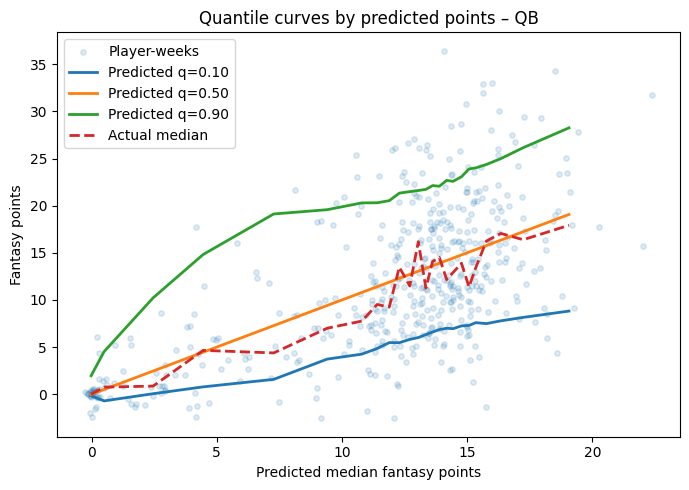

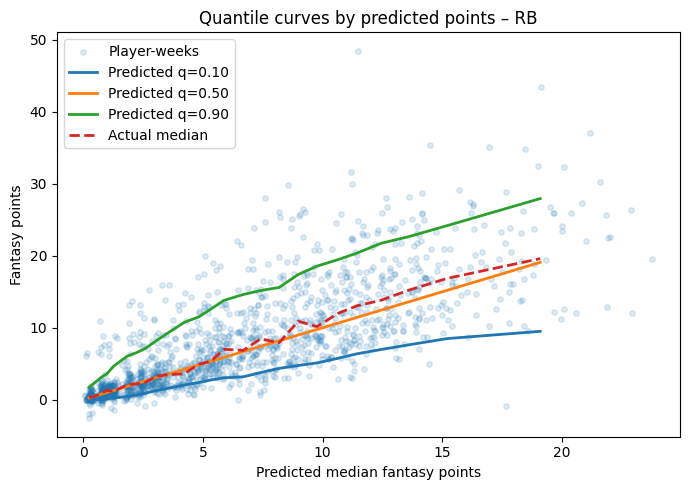

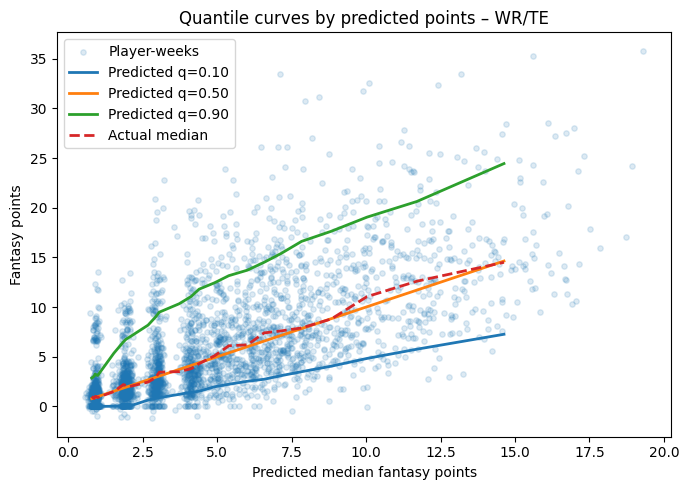

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_quantile_curves_by_position(df_predictions, position, n_bins=25):
    """
    Make a quantile fan plot for a single position, similar to the demo image:
      - x-axis: predicted median points (pred_50)
      - lines: avg predicted 10/50/90 quantiles
      - line: actual median in each bin (ground truth)
      - background: scatter of individual weeks
    """
    # Filter to this position
    df_pos = df_predictions[df_predictions['position'] == position].copy()
    if df_pos.empty:
        print(f"No rows found for position {position}")
        return

    # Sort by predicted median
    df_pos = df_pos.sort_values('pred_50')

    # Make quantile bins on pred_50 (avoid more bins than we have data for)
    nbins = min(n_bins, max(5, len(df_pos) // 20))
    df_pos['pred_bin'] = pd.qcut(df_pos['pred_50'], q=nbins, duplicates='drop')

    grouped = df_pos.groupby('pred_bin')

    # x = mean pred_50 in each bin
    x = grouped['pred_50'].mean()

    # predicted quantiles (averaged within bins)
    pred_q10 = grouped['pred_10'].mean()
    pred_q50 = grouped['pred_50'].mean()
    pred_q90 = grouped['pred_90'].mean()

    # "ground truth" curve: median actual in each bin
    actual_med = grouped['y_test'].median()

    # --- plot ---
    fig, ax = plt.subplots(figsize=(7, 5))

    # scatter points as background
    ax.scatter(df_pos['pred_50'], df_pos['y_test'],
               alpha=0.15, s=15, label='Player-weeks')

    # quantile curves
    ax.plot(x, pred_q10, linewidth=2, label='Predicted q=0.10')
    ax.plot(x, pred_q50, linewidth=2, label='Predicted q=0.50')
    ax.plot(x, pred_q90, linewidth=2, label='Predicted q=0.90')

    # ground truth median
    ax.plot(x, actual_med, linewidth=2, linestyle='--', label='Actual median')

    ax.set_xlabel('Predicted median fantasy points')
    ax.set_ylabel('Fantasy points')
    ax.set_title(f'Quantile curves by predicted points – {position}')
    ax.legend()
    plt.tight_layout()
    plt.show()




# Example: just QBs
plot_quantile_curves_by_position(df_predictions, position='QB')
plot_quantile_curves_by_position(df_predictions, position='RB')
plot_quantile_curves_by_position(df_predictions, position='WR/TE')